# Stroke Prediction Dataset

**11 clinical features for predicting stroke events**

*В данном исследовании попробуем предсказать инсульт у пациента, опираясь на различные характеристики. Датасет взят с [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)*

## 1. Импорты библиотек

In [252]:
import warnings
warnings.filterwarnings('ignore')

from functools import partial
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier, 
    VotingClassifier, 
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split, 
    cross_val_predict, 
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from catboost import CatBoostClassifier
from hyperopt import hp, fmin, STATUS_OK, tpe, Trials
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## 2. Загрузка датасета

Импортируем необходимые модули для работы с файлами и API Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from zipfile import ZipFile

Определим две константы. **DATASET_NAME** берём из Kaggle API команды, а в **PATH** запишем каталог, в который сохраним csv-файл с датасетом

In [3]:
DATASET_NAME = 'fedesoriano/stroke-prediction-dataset'
PATH = 'data'

In [4]:
def load_dataset():
    if not Path(PATH).is_dir():
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(DATASET_NAME, path=PATH)
        zip_path = PATH + '/' + DATASET_NAME.split('/')[1] + '.zip'
        with ZipFile(zip_path, 'r') as zip:
            zip.extractall(PATH)
        Path(zip_path).unlink(missing_ok=True)
    return pd.read_csv(Path(PATH).iterdir().__next__(), sep=',')

In [5]:
stroke = load_dataset()

## 3. Исследуем датасет

In [6]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Оценим размер датасета

In [7]:
stroke.shape

(5110, 12)

In [8]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Как видно, пропуски только в **bmi**. По остальным признакам пропуски отсутствуют

In [9]:
stroke.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


О нет! В **gender** мы видим 3 пола! Рассмотрим данный признак подробнее

In [10]:
stroke.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

У одного из пациентов (к счастью всего у одного) возникли проблемы с определением пола. Заменим Other на Female

In [11]:
stroke.replace('Other', 'Female', inplace=True)

In [12]:
stroke.gender.value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

In [13]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Можно увидеть, что инсульт был примерно у 5% испытуемых. Примерно столько же человек страдает от сердечных заболеваний. Повышенное давление наблюдается примерно у 10% пациентов. Средний возраст составляет примерно 43 года.

Проверим датасет на дубликаты

In [14]:
stroke.duplicated().sum()

0

Отлично, дубликатов нет!

Удалим сразу столбец **id**, так как он не представляет никакого интереса

In [15]:
stroke.drop('id', axis=1, inplace=True)

Далее рассмотрим, как распределены инсульты по разным группам пациентов

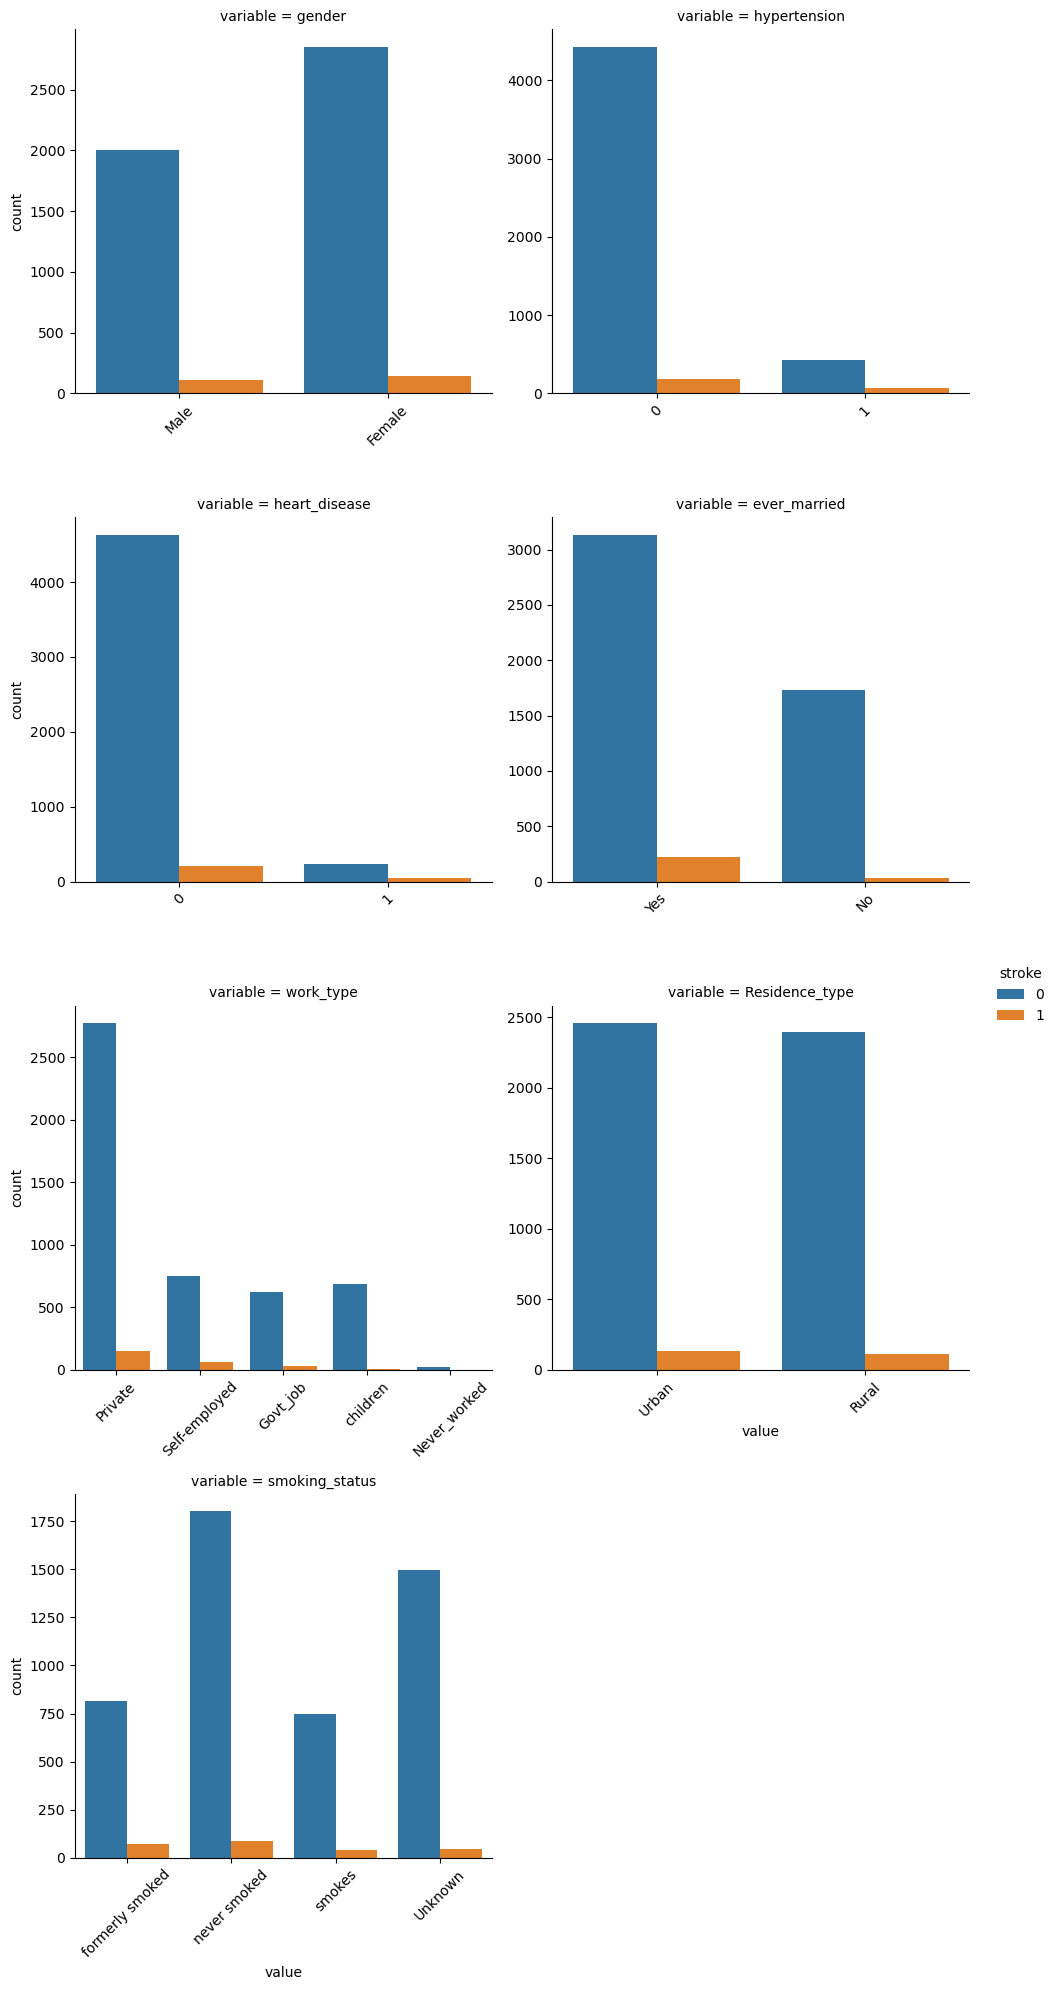

In [17]:
g=sns.catplot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

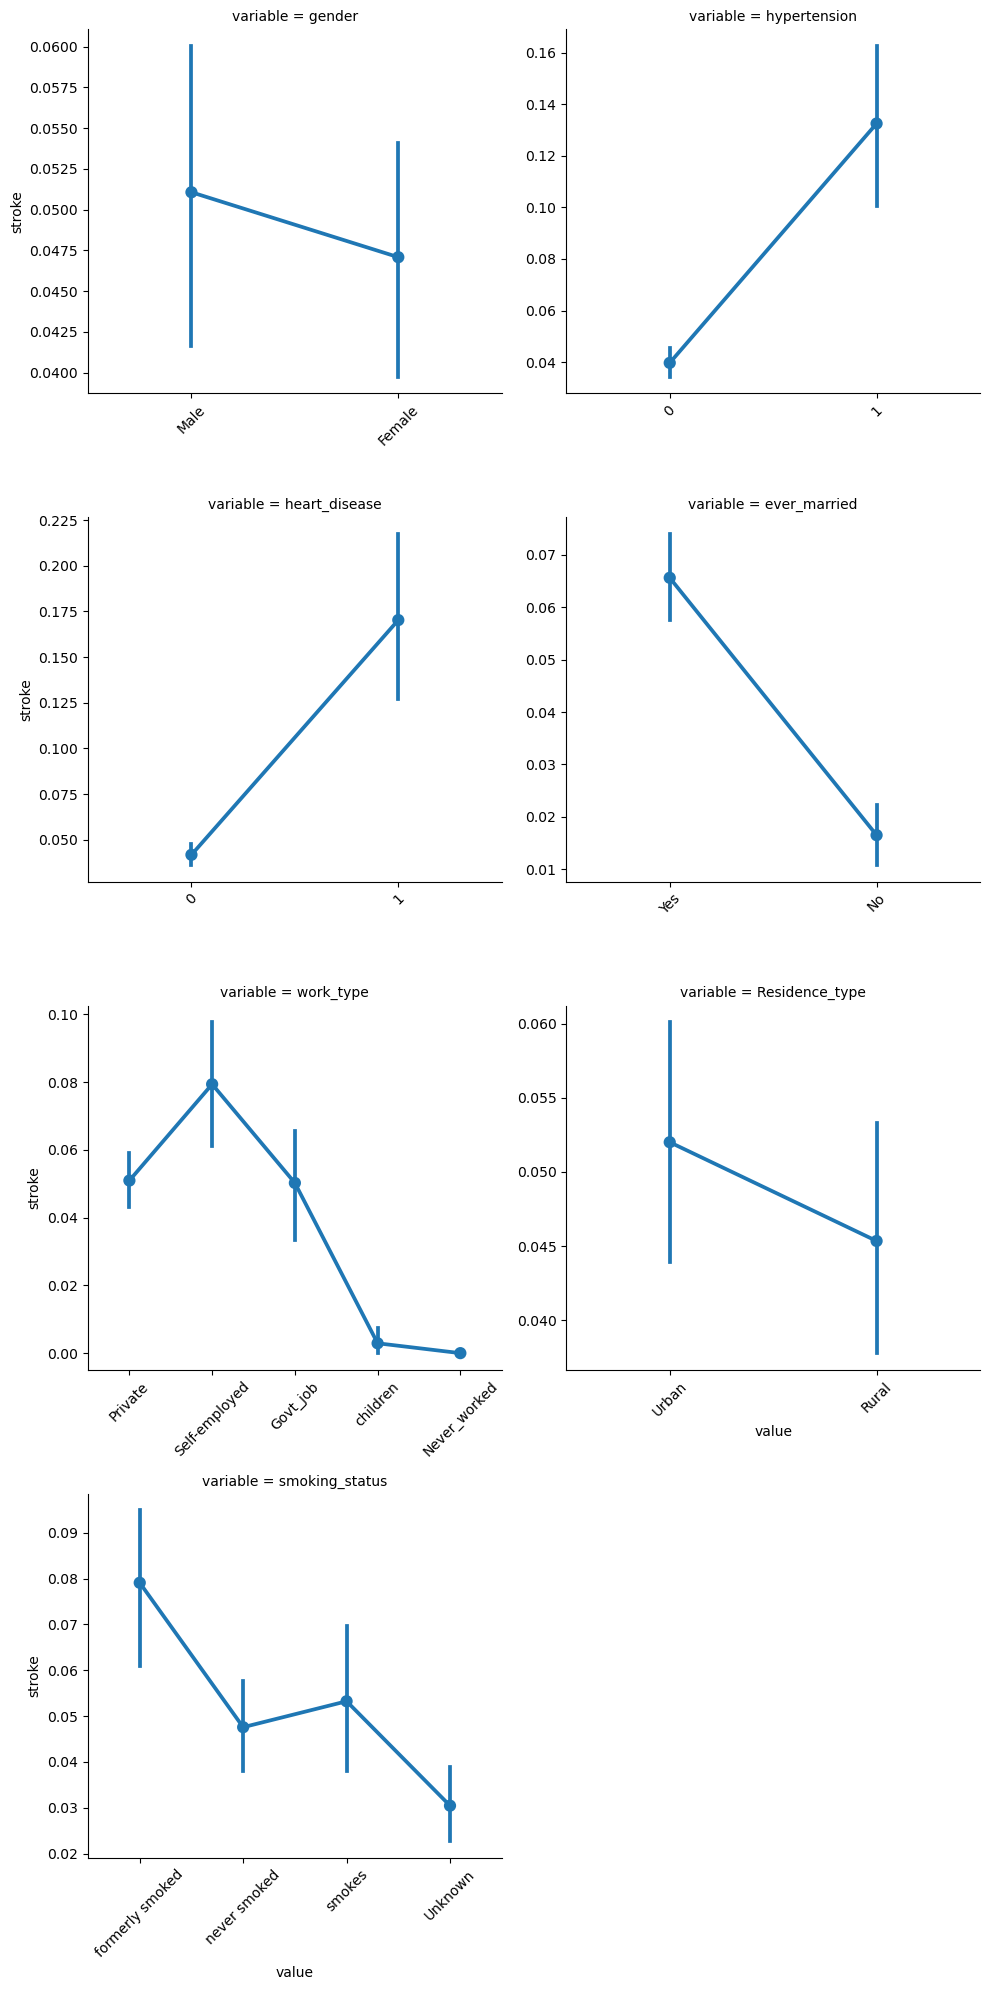

In [26]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можно увидеть из этих графиков:
- вероятность инсульта у мужчин немного выше, чем у женщин
- у пациентов с гипертонией вероятность инсульта примерно в 3 раза выше
- у пациентов с сердечными заболеваниями вероятность инсульта тоже примерно в 3 раза выше
- те, кто никогда не состоял в браке, заболевают инсультом более чем в 3 раза реже
- наиболее часто инсульт встречается у самозанятых и почти не встречается у тех, кто не работает (интересно получается!)
- бывшие курильщики больше других подвержены инсультам (даже больше чем курящие)
- живущие в городе чуть чаще подвержены инсультам

Рассмотрим, как выглядят признаки по половому различию

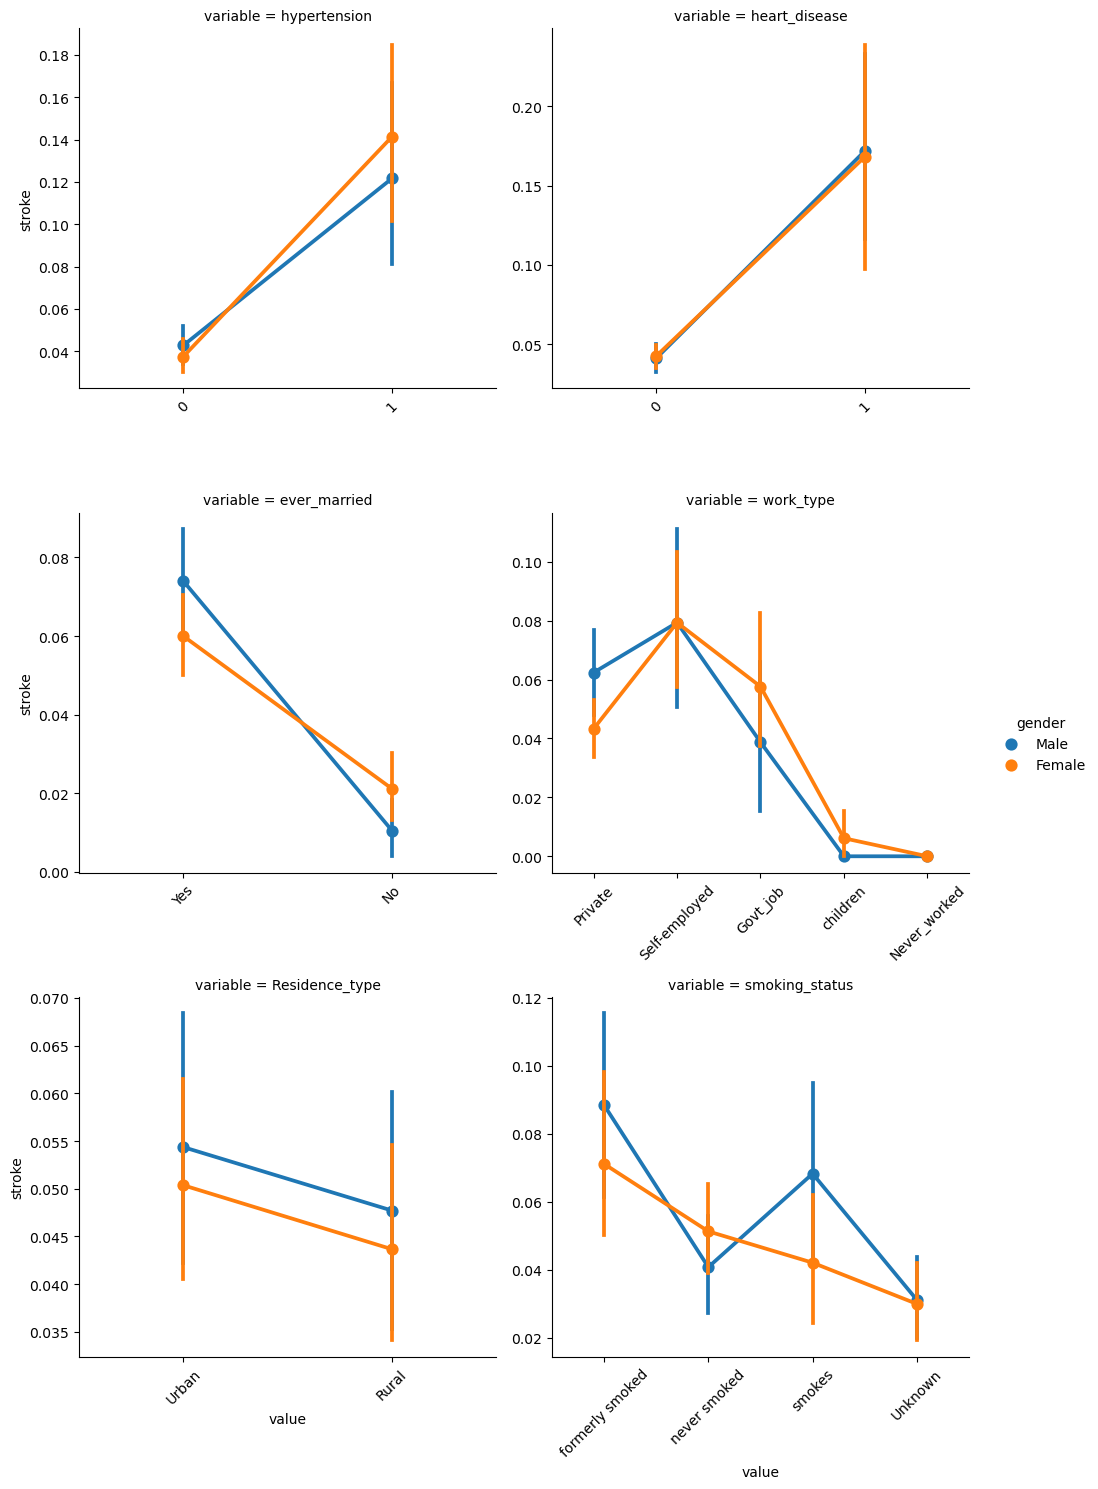

In [19]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke', 'gender'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    hue='gender',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Ничего существенного!

Теперь рассмотрим как распределены количественные признаки

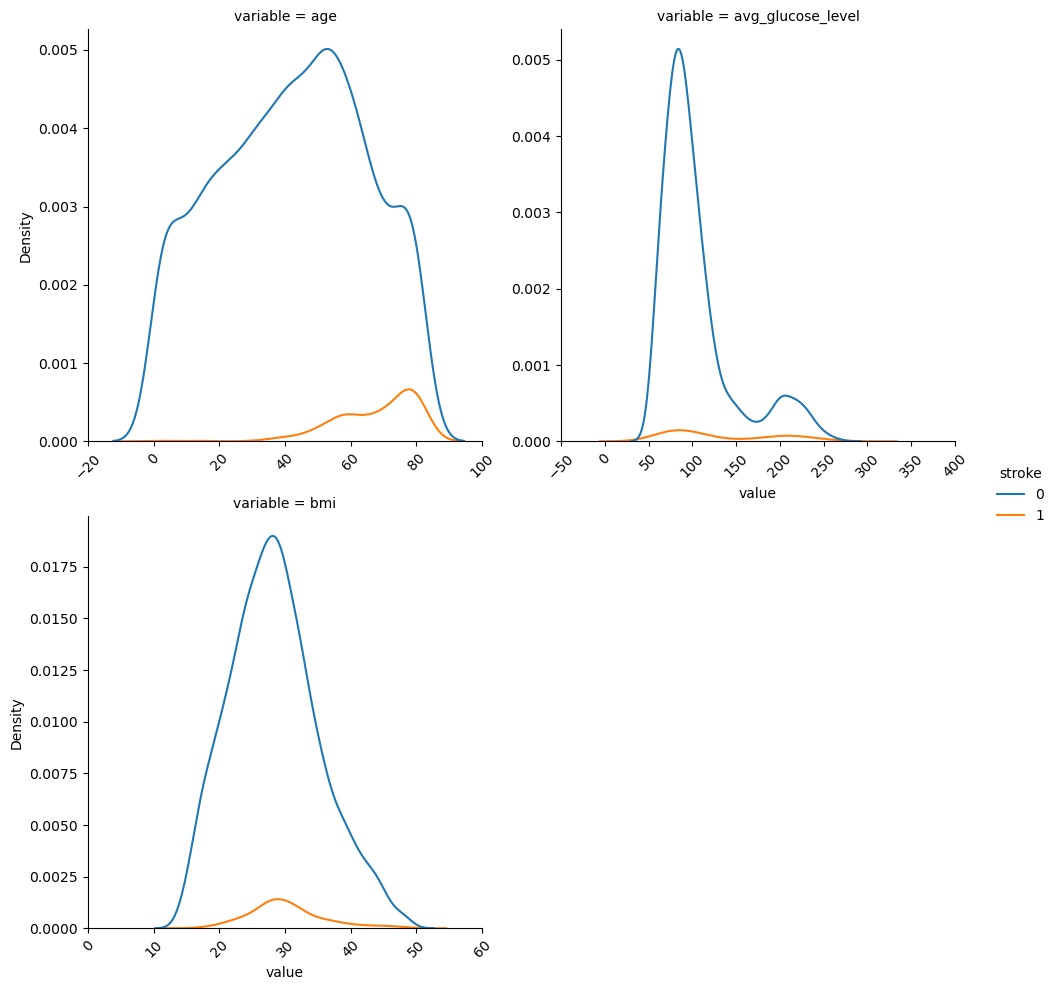

In [7]:
g=sns.displot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='kde',
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можного увидеть из этих графиков:
- по индексу **bmi** сколь значимого отличия нет, там и там максимум приходится примерно на 30
- по среднему уровню глюкозы в крови тоже не наблюдается отличий
- а вот по возрасту у пациентов с инсультом видно чёткое смещение пика к 80 годам

Теперь рассмотрим распределение уровня глюкозы от возраста 

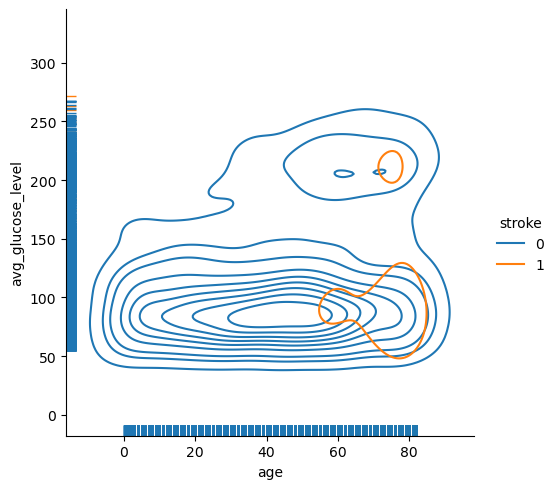

In [23]:
sns.displot(
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    data=stroke,
    kind='kde',
    rug=True
);

... и распределение **bmi** от возраста c учётом возможного инсульта

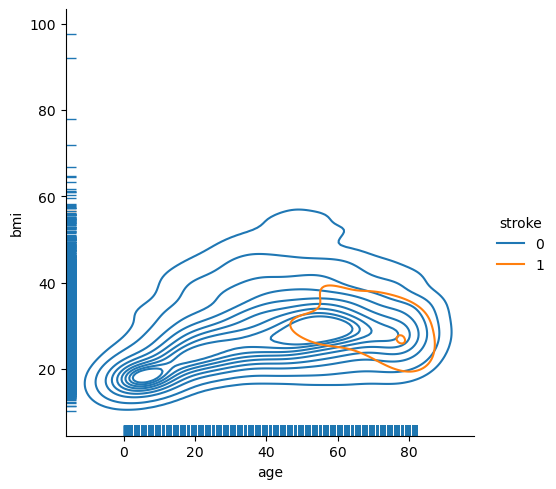

In [24]:
sns.displot(
    x='age',
    y='bmi',
    hue='stroke',
    data=stroke,
    kind='kde',
    rug=True
);

... и распределение bmi от индекса массы тела

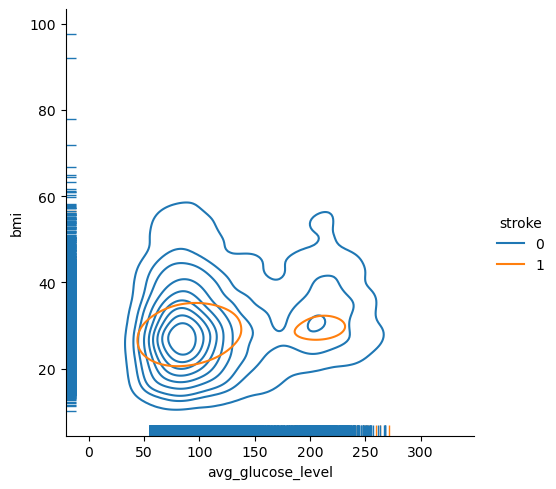

In [299]:
sns.displot(
    x='avg_glucose_level',
    y='bmi',
    hue='stroke',
    data=stroke,
    kind='kde',
    rug=True
);

Как видим, какое-то чёткое разделение отсутствует

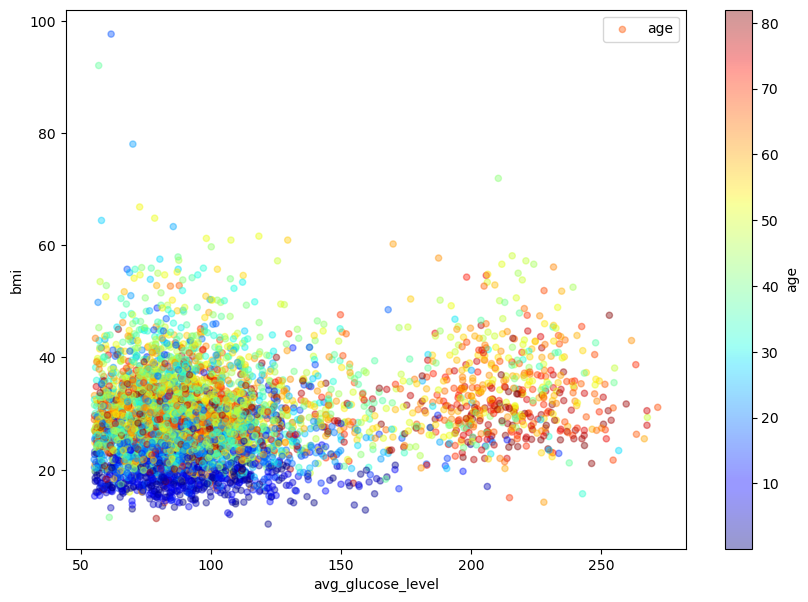

In [312]:
stroke.plot(
    kind="scatter", 
    x="avg_glucose_level", 
    y="bmi", 
    alpha=0.4,             
    label="age", 
    figsize=(10,7),
    c="age", 
    cmap="jet",
    colorbar=True,
    sharex=False)
plt.legend();

И напоследок рассмотрим, как распределён инсульт по возрастным группам

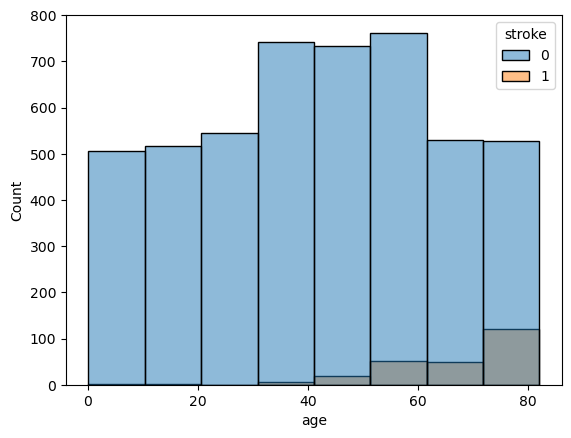

In [28]:
sns.histplot(
    x='age',
    data=stroke,
    hue='stroke',
    bins=8
);

Как видно, инсульт начинается проявляться после 40 лет, затем наблюдается рост после 50 лет, а потом после 70. При этом пациентов после 60 лет наблюдается меньше - то есть получается рост не только в абсолютных значениях, но и в относительных!

## 4. Подготовка данных (Data Preparation)

### 4.1 Получение базовых оценок

Для того, чтобы в дальнейшем понять, что мы движемся в верном направлении, получим базовые оценки на текущих данных. Но снаала вспомним, что категориальные признаки **gender**, **ever_married**, **Residence_type** имеют всего 2 варианта значений. Преобразуем их

In [16]:
stroke.gender = stroke.gender.map(lambda x: 1 if x == 'Male' else 0)

In [17]:
stroke.ever_married = stroke.ever_married.map(lambda x: 1 if x == 'Yes' else 0)

In [18]:
stroke.Residence_type = stroke.Residence_type.map(lambda x: 1 if x == 'Urban' else 0)

Разделим наш датасет на тестовый и тренировочный в соотношении 1/5. При этом стратифицируем выборку по целевому параметру, так как интересующих нас значений немного (примерно 5%)

In [484]:
stroke_train, stroke_test = train_test_split(stroke, test_size=0.2, random_state=42, stratify=stroke.stroke)

Также вспомним, что у признака **bmi** есть пропущенные значения. Заполним эти пропуски

In [485]:
stroke_train.bmi = stroke_train.bmi.fillna(stroke_train.bmi.mean())

Выделим метки

In [486]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [487]:
cat_columns = X_train.select_dtypes(object).columns

In [488]:
num_columns = X_train.select_dtypes(exclude=object).columns

Закодируем категориальные значения и нормализуем числовые

In [489]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [490]:
X_train_encoded = prep.fit_transform(X_train)

In [320]:
def make_scores(y_train, y_pred):
    print(f'accuracy_score = {accuracy_score(y_train, y_pred):0.3f} \n'
          f'precision_score = {precision_score(y_train, y_pred):0.3f} \n'
          f'recall_score = {recall_score(y_train, y_pred):0.3f} \n'
          f'f1_score = {f1_score(y_train, y_pred):0.3f} \n'
          f'roc_auc = {roc_auc_score(y_train, y_pred):0.3f}'
         )

Определим несколько классификаторов

In [321]:
sgd_clf = SGDClassifier(random_state=42, class_weight='balanced')
log_clf = LogisticRegression(random_state=42, class_weight='balanced')
svc_clf = LinearSVC(random_state=42, class_weight='balanced')
svm_clf = SVC(random_state=42, class_weight='balanced')
tre_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rnd_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [322]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [29]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
    print(clf.__class__.__name__)
    make_scores(y_train, y_train_pred)
    print('*'*10)

SGDClassifier
accuracy_score = 0.722 
precision_score = 0.109 
recall_score = 0.658 
f1_score = 0.187 
roc_auc = 0.692
**********
LogisticRegression
accuracy_score = 0.736 
precision_score = 0.131 
recall_score = 0.784 
f1_score = 0.224 
roc_auc = 0.759
**********
LinearSVC
accuracy_score = 0.731 
precision_score = 0.131 
recall_score = 0.804 
f1_score = 0.225 
roc_auc = 0.766
**********
SVC
accuracy_score = 0.758 
precision_score = 0.115 
recall_score = 0.593 
f1_score = 0.192 
roc_auc = 0.679
**********
DecisionTreeClassifier
accuracy_score = 0.919 
precision_score = 0.174 
recall_score = 0.176 
f1_score = 0.175 
roc_auc = 0.567
**********
RandomForestClassifier
accuracy_score = 0.951 
precision_score = 0.250 
recall_score = 0.005 
f1_score = 0.010 
roc_auc = 0.502
**********


In [29]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf, 
    ):
    score = cross_val_score(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, scoring='roc_auc')                            
    print(f'{clf.__class__.__name__}: ROC_AUC = {score.mean():0.3f} ± {score.std():0.3f}')

SGDClassifier: ROC_AUC = 0.762 ± 0.059
LogisticRegression: ROC_AUC = 0.836 ± 0.022
LinearSVC: ROC_AUC = 0.837 ± 0.021
SVC: ROC_AUC = 0.773 ± 0.009
DecisionTreeClassifier: ROC_AUC = 0.567 ± 0.018
RandomForestClassifier: ROC_AUC = 0.799 ± 0.026


Как видно, лучшие результаты дали **LogisticRegression** и **LinearSVC**

### 4.2 Feature engineering

Посмотрим, есть ли выбросы среди числовых признаков. Воспользуемся "ящиком с усами"

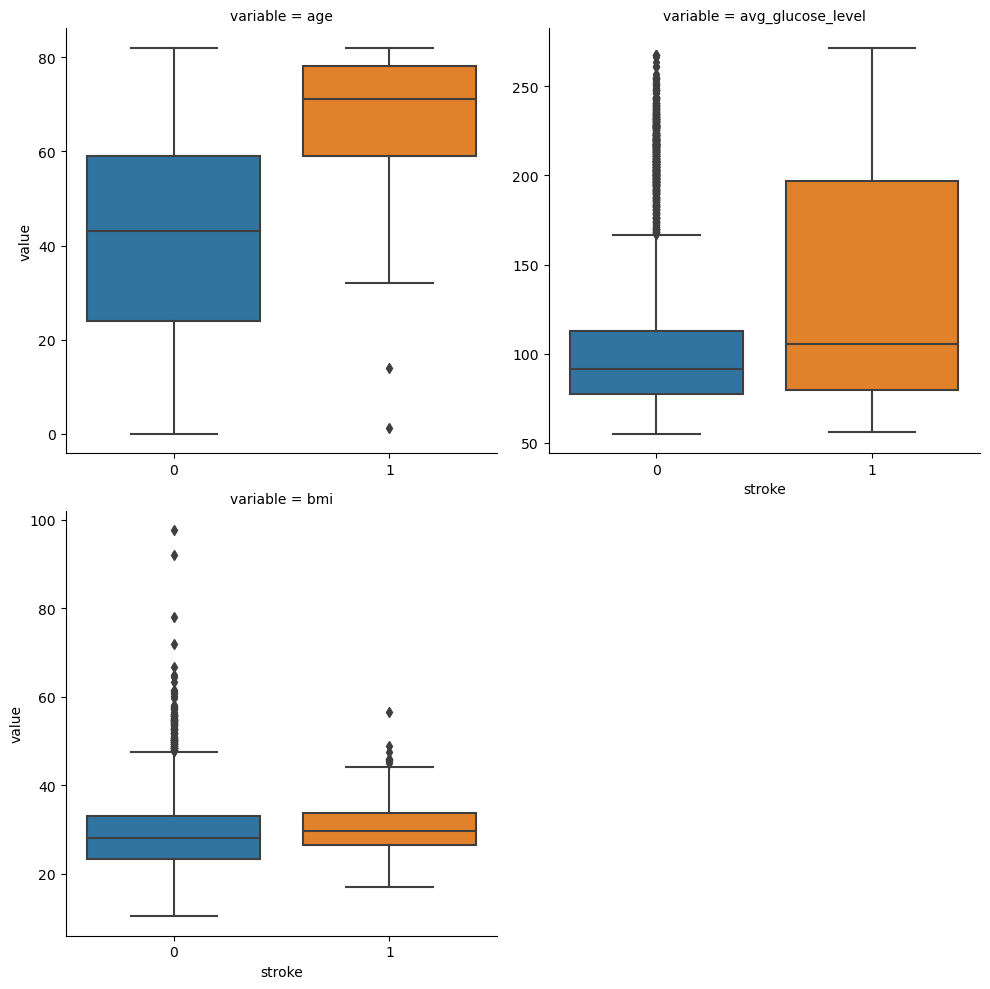

In [31]:
g=sns.catplot(
    y='value',
    x='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='box',
    col_wrap=2,
    sharex=False, 
    sharey=False,
)

Как видно, есть выбросы у **avg_glucose_level** и **bmi**. Определим функцию нахождения выбросов

In [112]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [113]:
boundaries = pd.DataFrame(calculate_outliers(X_train.select_dtypes(float)))
boundaries

,age,avg_glucose_level,bmi
0,-26.5,21.985,10.3
1,113.5,169.525,46.3


Вернёмся к выбросам чуть позже

Разделим всех наших пациентов на возрастные категории с шагом в 10 лет

In [491]:
stroke_train['age_category'] = stroke_train.age // 20 * 20
stroke_train[['age_category', 'stroke']].groupby(['age_category']).mean()

,stroke
age_category,
0.0,0.001311
20.0,0.002094
40.0,0.041864
60.0,0.117586
80.0,0.209790


Как видно, после 40 лет и каждые последующие 10 лет увеличивается вероятность инсульта 

Создадим параметр, который показывает, курил ли когда-либо пациент

In [492]:
stroke_train['ever_smoking'] = stroke_train.apply(lambda x: 1 
                                                  if x.smoking_status in ['smokes', 'formerly smoked'] 
                                                  else 0, axis=1)
stroke_train[['ever_smoking', 'stroke']].groupby(['ever_smoking']).mean()

,stroke
ever_smoking,
0,0.039665
1,0.067164


Следующий признак показывает, есть ли у пациента сахарный диабет

In [493]:
stroke_train['diabeth'] = stroke_train.avg_glucose_level.map(lambda x: 1 if x>150 else 0)
stroke_train[['diabeth', 'stroke']].groupby(['diabeth']).mean()

,stroke
diabeth,
0,0.036296
1,0.122241


Как видно, вероятность инсульта с диабетом в 4 раза выше!

In [494]:
stroke_train[['hypertension', 'stroke']].groupby(['hypertension']).mean()

,stroke
hypertension,
0,0.039285
1,0.136020


In [495]:
stroke_train[['heart_disease', 'stroke']].groupby(['heart_disease']).mean()

,stroke
heart_disease,
0,0.042152
1,0.162896


Просуммируем негативные факторы, влияющие на риск возникновения инсульта

In [496]:
stroke_train['diseases'] = stroke_train.apply(lambda x: x.diabeth+x.hypertension+x.heart_disease+x.ever_smoking, axis=1)
stroke_train[['diseases', 'stroke']].groupby(['diseases']).mean()

,stroke
diseases,
0,0.023245
1,0.050549
2,0.141148
3,0.153061
4,0.384615


Как видно, у пациентов с "полным набором" вероятность инсульта 38,5%

Рассмотрим, как возраст и количество негативных факторов влияет на вероятность инсульта

In [497]:
stroke_train[['age_category', 'diseases', 'stroke']].groupby(['age_category', 'diseases']).mean()

stroke
age_category diseases          
0.0          0         0.001439
             1         0.000000
             2         0.000000
20.0         0         0.000000
             1         0.003003
             2         0.024390
40.0         0         0.026087
             1         0.040385
             2         0.097902
             3         0.080000
             4         0.333333
60.0         0         0.078231
             1         0.098985
             2         0.185000
             3         0.169231
             4         0.375000
80.0         0         0.244898
             1         0.153846
             2         0.218750
             3         0.250000
             4         0.500000

Выведем корреляции признаков

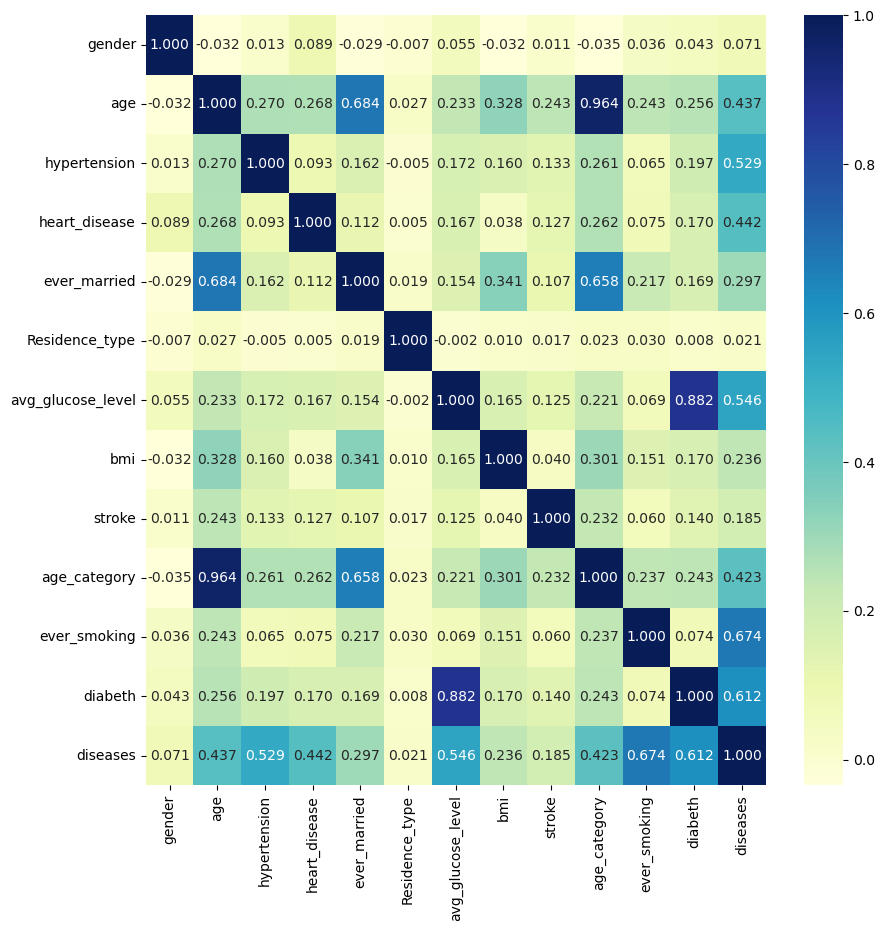

In [498]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    stroke_train.corr(), 
    annot=True, 
    cmap='YlGnBu',
    fmt='.3f',
);

In [499]:
stroke_train.corr()['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.243404
age_category         0.231599
diseases             0.184605
diabeth              0.140251
hypertension         0.133109
heart_disease        0.126883
avg_glucose_level    0.125328
ever_married         0.106979
ever_smoking         0.059983
bmi                  0.039680
Residence_type       0.016559
gender               0.010697
Name: stroke, dtype: float64

In [332]:
((stroke_train.corr() > 0.8) & (stroke_train.corr() != 1)).any()

gender               False
age                   True
hypertension         False
heart_disease        False
ever_married         False
Residence_type       False
avg_glucose_level     True
bmi                  False
stroke               False
age_category          True
ever_smoking         False
diabeth               True
diseases             False
dtype: bool

Видим, что **age** и **age_category** имеют сильную корреляцию. В свою очередь, **avg_glucose_level** имеет большую корреляцию с **diabeth**. Поэтому удаляем **age** и **avg_glucose_level**.

In [423]:
stroke_train = stroke_train.drop(['age_category', 'avg_glucose_level'], axis=1)

Удалим выбросы в **bmi**

In [424]:
stroke_train.bmi[stroke_train.bmi > boundaries.bmi.max()] = boundaries.bmi.max()

Снова выделим метки из тренировочного датасета

In [425]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [426]:
cat_columns = X_train.select_dtypes(object).columns

In [427]:
num_columns = X_train.select_dtypes(exclude=object).columns

In [428]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [429]:
X_train_encoded = prep.fit_transform(X_train)

In [64]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
    print(clf.__class__.__name__)
    make_scores(y_train, y_train_pred)
    print('*'*10)

SGDClassifier
accuracy_score = 0.629 
precision_score = 0.096 
recall_score = 0.784 
f1_score = 0.171 
roc_auc = 0.703
**********
LogisticRegression
accuracy_score = 0.733 
precision_score = 0.131 
recall_score = 0.794 
f1_score = 0.225 
roc_auc = 0.762
**********
LinearSVC
accuracy_score = 0.728 
precision_score = 0.130 
recall_score = 0.804 
f1_score = 0.224 
roc_auc = 0.764
**********
SVC
accuracy_score = 0.747 
precision_score = 0.109 
recall_score = 0.583 
f1_score = 0.183 
roc_auc = 0.669
**********
DecisionTreeClassifier
accuracy_score = 0.916 
precision_score = 0.144 
recall_score = 0.146 
f1_score = 0.145 
roc_auc = 0.551
**********
RandomForestClassifier
accuracy_score = 0.942 
precision_score = 0.115 
recall_score = 0.030 
f1_score = 0.048 
roc_auc = 0.509
**********


In [49]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf, 
    ):
    score = cross_val_score(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, scoring='roc_auc')                            
    print(f'{clf.__class__.__name__}: ROC_AUC = {score.mean():0.3f} ± {score.std():0.3f}')

SGDClassifier: ROC_AUC = 0.773 ± 0.070
LogisticRegression: ROC_AUC = 0.833 ± 0.025
LinearSVC: ROC_AUC = 0.834 ± 0.025
SVC: ROC_AUC = 0.765 ± 0.009
DecisionTreeClassifier: ROC_AUC = 0.551 ± 0.022
RandomForestClassifier: ROC_AUC = 0.759 ± 0.030


В целом оценки получились схожими с базовыми

## 5. Моделирование

Попробуем потюнить наши модели. Для подбора гиперпараметров будем использовать _HyperOpt_. Определим несколько вспомогательных функций

In [137]:
def objective(params, model,  X_train, y_train):
    model.set_params(**params)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    return   {'loss': -score.mean(), 'params': params, 'loss_std': -score.std(), 'status': STATUS_OK}

In [138]:
def get_results(hp_results):
    results = pd.DataFrame([
        {**x, **{'loss_func' if k == 'loss' else k:v for k,v in x['params'].items()}} 
        for x in hp_results
    ])
    results.drop(['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=True, inplace=True)
    return results

### 5.1 SGDClassifier

In [433]:
sgd_clf = SGDClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

In [434]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l1',
        'alpha': hp.uniform('alpha1', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping1', [False, True]),
        'loss' : hp.choice('loss1', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
    {
        'penalty' : 'l2',
        'alpha': hp.uniform('alpha2', 1e-6, 1e-3),
        'early_stopping' : hp.choice('early_stopping2', [False, True]),
        'loss' : hp.choice('loss2', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
    {
        'penalty' : 'elasticnet',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'alpha': hp.uniform('alpha3', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping3', [False, True]),
        'loss' : hp.choice('loss3', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
])

In [435]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=sgd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:04<00:00, 20.23trial/s, best loss: -0.8435309414168266]


In [436]:
best

{'alpha': 0.00904182325593402,
 'early_stopping': False,
 'l1_ratio': 0.6924501032990741,
 'loss': 'log',
 'penalty': 'elasticnet'}

In [437]:
result = get_results(trials.results)
result

,loss,loss_std,alpha,early_stopping,loss_func,penalty,l1_ratio
76,-0.843531,-0.022181,0.009042,False,log,elasticnet,0.692450
99,-0.843501,-0.022074,0.008788,False,log,elasticnet,0.684385
71,-0.843475,-0.022062,0.009028,False,log,elasticnet,0.665507
69,-0.843271,-0.021886,0.008520,False,log,elasticnet,0.647680
70,-0.843242,-0.021915,0.008510,False,log,elasticnet,0.654022
...,...,...,...,...,...,...,...
55,-0.716008,-0.112840,0.004880,False,squared_hinge,l1,NaN
92,-0.713979,-0.092455,0.000099,True,modified_huber,l2,NaN
42,-0.713513,-0.102954,0.004153,False,squared_hinge,l1,NaN
90,-0.672327,-0.142542,0.009038,False,squared_hinge,elasticnet,0.976984


In [438]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8435309414168266


За счёт подбора параметров, ROC_AUC удалось поднять на 6%. Но данный показатель не является оптимальным - скорей всего мы получим низкую точность модели при приемлемой полноте. Видно, что дучшие результаты были получены со штрафом l1 (Lasso). А мы помним, что Лассо-регрессия исключает маловажные признаки, то есть даёт разреженную модель. Давайте посмотрим, какие признаки были исключены

In [439]:
sgd_clf.set_params(**best)

SGDClassifier(alpha=0.00904182325593402, class_weight='balanced',
              l1_ratio=0.6924501032990741, loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

In [440]:
sgd_clf.fit(X_train_encoded, y_train)

SGDClassifier(alpha=0.00904182325593402, class_weight='balanced',
              l1_ratio=0.6924501032990741, loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

In [441]:
sorted(zip(sgd_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(1.5802985895750672, 'num__age'),
 (0.2092905716239186, 'num__diseases'),
 (0.06480454798349651, 'num__diabeth'),
 (0.057789687546194825, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__gender'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__bmi'),
 (0.0, 'num__Residence_type'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Как видно, самый важный признак это **age_category**. И это вполне предсказуемо

Посмотрим значение свободного члена

In [442]:
sgd_clf.intercept_

array([-1.11186094])

In [443]:
y_pred = sgd_clf.predict(X_test_encoded)

In [444]:
make_scores(y_test, y_pred)

accuracy_score = 0.749 
precision_score = 0.139 
recall_score = 0.800 
f1_score = 0.237 
roc_auc = 0.773


In [445]:
confusion_matrix(y_test, y_pred)

array([[725, 247],
       [ 10,  40]], dtype=int64)

### 5.2 Logistic Regression

In [446]:
log_clf = LogisticRegression(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1,
    tol = 1e-3
)

In [447]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e2),
        'solver' : hp.choice('solver1', ['liblinear', 'saga']),
    },
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-4, 1e2),
        'solver' : hp.choice('solver2', ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']),
    },
    {
        'penalty' : 'none',
        'C': hp.uniform('C3', 1e-4, 1e2),
        'solver' : hp.choice('solver3', ['newton-cg', 'lbfgs', 'sag', 'saga']),
    },
    {
        'penalty' : 'elasticnet',
        'C': hp.uniform('C4', 1e-4, 1e2),
        'solver' : 'saga',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1)
    },
])

In [448]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=log_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:15<00:00,  6.61trial/s, best loss: -0.8440696571346744]


In [449]:
best

{'C': 0.0067228918458610565,
 'l1_ratio': 0.8953697692847011,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [450]:
result = get_results(trials.results)
result

,loss,loss_std,C,penalty,solver,l1_ratio
58,-0.844070,-0.021439,0.006723,elasticnet,saga,0.895370
72,-0.839724,-0.021282,0.193602,l1,liblinear,NaN
85,-0.839385,-0.021237,0.379414,l1,liblinear,NaN
44,-0.838693,-0.021564,1.008719,l1,liblinear,NaN
32,-0.838620,-0.021581,1.138819,l1,liblinear,NaN
...,...,...,...,...,...,...
90,-0.761650,-0.085758,33.073610,none,saga,NaN
65,-0.759785,-0.085184,78.278529,elasticnet,saga,0.965407
8,-0.757807,-0.083958,77.138105,l1,saga,NaN
51,-0.750981,-0.081438,88.989983,l1,saga,NaN


In [451]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8440696571346744


Результат сравнимый с полученным выше! При этом прироста результата нет

In [452]:
log_clf.set_params(**best)

LogisticRegression(C=0.0067228918458610565, class_weight='balanced',
                   l1_ratio=0.8953697692847011, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [453]:
log_clf.fit(X_train_encoded, y_train)

LogisticRegression(C=0.0067228918458610565, class_weight='balanced',
                   l1_ratio=0.8953697692847011, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [454]:
sorted(zip(log_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(1.2955527553504083, 'num__age'),
 (0.21649714077937074, 'num__diseases'),
 (0.050155585438380064, 'num__diabeth'),
 (0.003618374583073965, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__gender'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__bmi'),
 (0.0, 'num__Residence_type'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Да, те же самые признаки, что и у **SGDClassifier**. Это неудивительно, так как мы получили эластичную сеть с параметром R=0.89 (l1_ratio), то есть максимально приближенную к Лассо регрессии. Посмотрим значение свободного члена

In [455]:
log_clf.intercept_

array([-0.86964384])

In [456]:
y_pred = log_clf.predict(X_test_encoded)

In [457]:
make_scores(y_test, y_pred)

accuracy_score = 0.735 
precision_score = 0.133 
recall_score = 0.800 
f1_score = 0.228 
roc_auc = 0.766


In [458]:
confusion_matrix(y_test, y_pred)

array([[711, 261],
       [ 10,  40]], dtype=int64)

### 5.3 LinearSVC

In [373]:
svc_clf = LinearSVC(random_state=42, class_weight='balanced')

In [374]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-6, 1e3),
        'loss' : hp.choice('loss1', ['hinge', 'squared_hinge']),
        'dual': True
    },
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e2),
        'loss' : hp.choice('loss2', ['squared_hinge']),
        'dual': False
    }
])

In [375]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=svc_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:21<00:00,  4.72trial/s, best loss: -0.8377026679056281]


In [376]:
best

{'C': 0.19319753416764093,
 'dual': False,
 'loss': 'squared_hinge',
 'penalty': 'l1'}

In [377]:
result = get_results(trials.results)
result

,loss,loss_std,C,dual,loss_func,penalty
82,-0.837703,-0.021399,0.193198,False,squared_hinge,l1
70,-0.837553,-0.021329,0.251280,False,squared_hinge,l1
33,-0.837532,-0.021358,0.262796,False,squared_hinge,l1
43,-0.837409,-0.021318,0.347438,False,squared_hinge,l1
65,-0.837388,-0.021314,0.350165,False,squared_hinge,l1
...,...,...,...,...,...,...
7,-0.580803,-0.053528,830.089633,True,hinge,l2
2,-0.580803,-0.053528,73.661026,True,hinge,l2
44,-0.580803,-0.053528,264.336970,True,hinge,l2
19,-0.580803,-0.053528,713.044522,True,hinge,l2


In [378]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8377026679056281


Результат аналогичен ранее полученным

In [379]:
svc_clf.set_params(**best)

LinearSVC(C=0.19319753416764093, class_weight='balanced', dual=False,
          penalty='l1', random_state=42)

In [380]:
svc_clf.fit(X_train_encoded, y_train)

LinearSVC(C=0.19319753416764093, class_weight='balanced', dual=False,
          penalty='l1', random_state=42)

In [381]:
sorted(zip(svc_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(0.9598965597496445, 'num__age'),
 (0.6359041739470962, 'cat__work_type_children'),
 (0.08825228916958709, 'num__diabeth'),
 (0.08224674710555914, 'num__diseases'),
 (0.02510903050803878, 'num__hypertension'),
 (0.024845196728401, 'num__bmi'),
 (0.022798598248504512, 'num__Residence_type'),
 (0.007264921144723093, 'cat__smoking_status_smokes'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__smoking_status_Unknown'),
 (-0.00034542508446798513, 'num__heart_disease'),
 (-0.0042201525471263915, 'cat__work_type_Govt_job'),
 (-0.018084600963415604, 'num__gender'),
 (-0.04225640553047823, 'num__ever_married'),
 (-0.04376477939213621, 'num__avg_glucose_level'),
 (-0.054061474975195846, 'cat__smoking_status_formerly smoked'),
 (-0.06743251321360381, 'cat__smoking_status_never smoked'),
 (-0.07648756898588265, 'cat__work_type_Self-employed'),
 (-0.25135056381863186, 'num__age_category')]

Как видно, данная модель использовала гораздо больше признаков

In [382]:
svc_clf.intercept_

array([-0.4215379])

In [383]:
y_pred = svc_clf.predict(X_test_encoded)

In [384]:
make_scores(y_test, y_pred)

accuracy_score = 0.750 
precision_score = 0.143 
recall_score = 0.820 
f1_score = 0.243 
roc_auc = 0.783


In [385]:
confusion_matrix(y_test, y_pred)

array([[726, 246],
       [  9,  41]], dtype=int64)

### 5.4 SVC

In [52]:
svm_clf = SVC(random_state=42, class_weight='balanced')

Линейное ядро рассматривать не будем, полиномиальное тоже, так как это будет слишком медленно

In [53]:
param_grid = hp.choice('kernel',[
    {
        'kernel' : 'rbf',
        'C': hp.uniform('C1', 1e-2, 1e2),
        'gamma' : hp.uniform('gamma1', 0.01, 1),
    },
    {
        'kernel' : 'sigmoid',
        'C': hp.uniform('C2', 1e-2, 1e2),
        'coef0' : hp.uniform('coef0', 0, 1),
        'gamma' : hp.uniform('gamma2', 0.01, 1),
    },
])

In [54]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=svm_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [01:16<00:00,  1.30trial/s, best loss: -0.8195305565827007]


In [55]:
best

{'C': 4.735858723063932, 'gamma': 0.011630374872080863, 'kernel': 'rbf'}

In [56]:
result = get_results(trials.results)
result

,loss,loss_std,C,gamma,kernel,coef0
70,-0.819531,-0.020989,4.735859,0.011630,rbf,NaN
82,-0.813615,-0.016817,0.036085,0.118602,rbf,NaN
66,-0.807368,-0.018180,9.266389,0.012582,rbf,NaN
30,-0.803924,-0.015488,0.050170,0.177124,rbf,NaN
29,-0.792674,-0.013026,31.810463,0.010059,rbf,NaN
...,...,...,...,...,...,...
91,-0.620865,-0.082712,31.694105,0.442364,sigmoid,0.196296
11,-0.619276,-0.075697,30.787382,0.612071,sigmoid,0.104831
18,-0.618543,-0.055815,41.722097,0.851356,sigmoid,0.128077
59,-0.613368,-0.078010,13.729145,0.364884,sigmoid,0.553615


In [57]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8195305565827007


Удалось добиться прироста 5% относительно базового показателя, но получилось в целом хуже, чем у других классификаторов

### 5.5 DecisionTreeClassifier

In [386]:
tre_clf = DecisionTreeClassifier(
    random_state=42, 
    class_weight='balanced'
)

In [387]:
param_grid = {
    'max_depth': hp.randint('max_depth', 1, 200),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 200),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 100),
}

In [388]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=tre_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:03<00:00, 29.41trial/s, best loss: -0.8265034345485495]


In [389]:
best

{'max_depth': 120,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 99,
 'min_samples_split': 45}

In [390]:
result = get_results(trials.results)
result

,loss,loss_std,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split
40,-0.826503,-0.017494,120,8,99,45
39,-0.821288,-0.026523,141,8,71,45
69,-0.820206,-0.019517,195,149,99,43
67,-0.820206,-0.019517,193,137,99,37
66,-0.820206,-0.019517,62,25,99,45
...,...,...,...,...,...,...
7,-0.699403,-0.033934,166,158,7,48
10,-0.677934,-0.011182,9,106,4,8
32,-0.674310,-0.033573,83,71,13,3
92,-0.671490,-0.024195,176,122,9,19


In [391]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8265034345485495


Точность улучшилась почти на 30%, относительно базовой оценки! Но в целом хуже

In [392]:
tre_clf.set_params(**best)

DecisionTreeClassifier(class_weight='balanced', max_depth=120, max_leaf_nodes=8,
                       min_samples_leaf=99, min_samples_split=45,
                       random_state=42)

In [393]:
tre_clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=120, max_leaf_nodes=8,
                       min_samples_leaf=99, min_samples_split=45,
                       random_state=42)

In [394]:
sorted(zip(tre_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.8700741331466505, 'num__age'),
 (0.07199339008793827, 'num__bmi'),
 (0.05793247676541122, 'num__diseases'),
 (0.0, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__gender'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__diabeth'),
 (0.0, 'num__avg_glucose_level'),
 (0.0, 'num__age_category'),
 (0.0, 'num__Residence_type'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Как видно, лучшая модель использовала всего 3 признака

In [395]:
y_pred = tre_clf.predict(X_test_encoded)

In [396]:
make_scores(y_test, y_pred)

accuracy_score = 0.760 
precision_score = 0.145 
recall_score = 0.800 
f1_score = 0.246 
roc_auc = 0.779


In [397]:
confusion_matrix(y_test, y_pred)

array([[737, 235],
       [ 10,  40]], dtype=int64)

### 5.6 RandomForestClassifier

In [459]:
rnd_clf = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

In [460]:
param_grid = {
    'max_depth': hp.randint('max_depth', 1, 100),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 100),
    'n_estimators': hp.randint('n_estimators', 100, 1000),
    'max_samples': hp.uniform('max_samples', 0, 1),
}

In [461]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=rnd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [05:23<00:00,  3.24s/trial, best loss: -0.8395654544283804]


In [462]:
best

{'max_depth': 66,
 'max_leaf_nodes': 85,
 'max_samples': 0.4911342969632798,
 'min_samples_leaf': 38,
 'min_samples_split': 82,
 'n_estimators': 823}

In [463]:
result = get_results(trials.results)
result

,loss,loss_std,max_depth,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators
65,-0.839565,-0.019560,66,85,0.491134,38,82,823
18,-0.839278,-0.019427,86,85,0.128077,19,26,981
71,-0.839104,-0.021399,57,42,0.650488,28,66,695
5,-0.838978,-0.019565,66,17,0.441943,38,75,760
20,-0.838845,-0.019272,66,85,0.484491,38,82,626
...,...,...,...,...,...,...,...,...
44,-0.808816,-0.015903,4,8,0.126630,89,43,722
49,-0.806889,-0.014209,81,85,0.039965,37,26,186
95,-0.805912,-0.018883,50,85,0.026474,29,35,475
35,-0.500000,-0.000000,32,58,0.011711,48,94,907


In [464]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8395654544283804


Немного лучше, чем у **DecisionTreeClassifier**. 

In [465]:
rnd_clf.set_params(**best)

RandomForestClassifier(class_weight='balanced', max_depth=66, max_leaf_nodes=85,
                       max_samples=0.4911342969632798, min_samples_leaf=38,
                       min_samples_split=82, n_estimators=823, n_jobs=-1,
                       oob_score=True, random_state=42)

In [466]:
rnd_clf.fit(X_train_encoded, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=66, max_leaf_nodes=85,
                       max_samples=0.4911342969632798, min_samples_leaf=38,
                       min_samples_split=82, n_estimators=823, n_jobs=-1,
                       oob_score=True, random_state=42)

Давайте посмотрим, какую точность мы имеем на неиспользуемом наборе данных (oob)

In [467]:
rnd_clf.oob_score_

0.7416829745596869

In [468]:
sorted(zip(rnd_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.5301655406420824, 'num__age'),
 (0.11005881355277854, 'num__bmi'),
 (0.08983845819573187, 'num__diseases'),
 (0.0538594082469434, 'num__ever_married'),
 (0.0424199000196787, 'num__diabeth'),
 (0.034045475373037065, 'cat__work_type_children'),
 (0.026478465448046235, 'num__hypertension'),
 (0.01734194415460552, 'num__heart_disease'),
 (0.014697232199903596, 'num__Residence_type'),
 (0.01231155785597999, 'cat__work_type_Self-employed'),
 (0.011636367578442407, 'num__gender'),
 (0.010077526917428893, 'cat__work_type_Private'),
 (0.00971834479486002, 'num__ever_smoking'),
 (0.009427266124736645, 'cat__smoking_status_never smoked'),
 (0.009423539920202242, 'cat__smoking_status_formerly smoked'),
 (0.007975181304589655, 'cat__smoking_status_Unknown'),
 (0.005795450157475691, 'cat__smoking_status_smokes'),
 (0.004729527513477225, 'cat__work_type_Govt_job'),
 (0.0, 'cat__work_type_Never_worked')]

Как видно, модель использовала почти все доступные признаки

In [469]:
y_pred = rnd_clf.predict(X_test_encoded)

In [470]:
make_scores(y_test, y_pred)

accuracy_score = 0.746 
precision_score = 0.138 
recall_score = 0.800 
f1_score = 0.235 
roc_auc = 0.771


In [471]:
confusion_matrix(y_test, y_pred)

array([[722, 250],
       [ 10,  40]], dtype=int64)

### 5.7 AdaBoostClasifier

Теперь попробуем бустинги! Начнём с адаптивного бустинга. Пробуем классификатор на "пеньках"

In [158]:
ada_clf1 = AdaBoostClassifier(random_state=42)

In [159]:
ada_clf1.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [161]:
param_grid = {
    'n_estimators': hp.randint('n_estimators', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
}

In [162]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=ada_clf1, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [01:52<00:00,  1.13s/trial, best loss: -0.8373158897566108]


In [163]:
best

{'learning_rate': 0.0806530144006623, 'n_estimators': 382}

In [164]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,n_estimators
36,-0.837316,-0.024900,0.080653,382
92,-0.836845,-0.022060,0.165467,272
28,-0.836763,-0.023475,0.078647,481
21,-0.836060,-0.027069,0.266959,77
93,-0.835548,-0.019535,0.199391,318
...,...,...,...,...
59,-0.465443,-0.150732,3.341048,157
25,-0.465443,-0.150732,3.427569,127
44,-0.450757,-0.153563,2.568766,83
94,-0.428494,-0.112109,2.224953,316


In [165]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8373158897566108


В целом не плохо!

In [166]:
ada_clf1.set_params(**best)

AdaBoostClassifier(learning_rate=0.0806530144006623, n_estimators=382,
                   random_state=42)

In [167]:
ada_clf1.fit(X_train_encoded, y_train)

AdaBoostClassifier(learning_rate=0.0806530144006623, n_estimators=382,
                   random_state=42)

In [168]:
sorted(zip(ada_clf1.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.5157068062827225, 'num__bmi'),
 (0.35340314136125656, 'num__age_category'),
 (0.06544502617801047, 'num__diseases'),
 (0.028795811518324606, 'num__ever_married'),
 (0.013089005235602094, 'num__diabeth'),
 (0.010471204188481676, 'num__hypertension'),
 (0.007853403141361256, 'num__gender'),
 (0.005235602094240838, 'num__Residence_type'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Как видно, данная модель отдала предпочтение параметру **bmi**. Теперь попробуем тоже самое, но с балансировкой

In [169]:
ada_clf2 = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        max_depth=1,
        class_weight='balanced'
    ), 
    random_state=42)

In [170]:
param_grid = {
    'n_estimators': hp.randint('n_estimators', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
}

In [171]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=ada_clf2, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [02:44<00:00,  1.65s/trial, best loss: -0.8375476699948756]


In [172]:
best

{'learning_rate': 0.0806530144006623, 'n_estimators': 382}

In [173]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,n_estimators
36,-0.837548,-0.024871,0.080653,382
28,-0.836930,-0.023355,0.078647,481
21,-0.836765,-0.026421,0.266959,77
69,-0.836699,-0.021869,0.321115,153
92,-0.836598,-0.022039,0.165467,272
...,...,...,...,...
50,-0.234677,-0.017840,6.386149,270
55,-0.234677,-0.017840,2.091582,150
64,-0.234677,-0.017840,8.901612,218
75,-0.234677,-0.017840,2.004488,302


In [174]:
ada_clf2.set_params(**best)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   learning_rate=0.0806530144006623, n_estimators=382,
                   random_state=42)

In [175]:
ada_clf2.fit(X_train_encoded, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   learning_rate=0.0806530144006623, n_estimators=382,
                   random_state=42)

In [176]:
sorted(zip(ada_clf2.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.5078534031413613, 'num__bmi'),
 (0.3612565445026178, 'num__age_category'),
 (0.06544502617801047, 'num__diseases'),
 (0.028795811518324606, 'num__ever_married'),
 (0.013089005235602094, 'num__diabeth'),
 (0.010471204188481676, 'num__hypertension'),
 (0.007853403141361256, 'num__gender'),
 (0.005235602094240838, 'num__Residence_type'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Попробуем немного изменить параметры

In [177]:
ada_clf3 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42)

In [178]:
param_grid = {
    'base_estimator__max_depth': hp.randint('max_depth', 1, 200),
    'base_estimator__max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 200),
    'base_estimator__min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'base_estimator__min_samples_split': hp.randint('min_samples_split', 2, 100),
    'n_estimators': hp.randint('n_estimators', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
}

In [179]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=ada_clf3, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [03:18<00:00,  1.98s/trial, best loss: -0.8123824740013625]


In [180]:
best

{'base_estimator__max_depth': 92,
 'base_estimator__max_leaf_nodes': 84,
 'base_estimator__min_samples_leaf': 75,
 'base_estimator__min_samples_split': 6,
 'learning_rate': 0.07345044038480841,
 'n_estimators': 101}

In [181]:
result = get_results(trials.results)
result

,loss,loss_std,base_estimator__max_depth,base_estimator__max_leaf_nodes,base_estimator__min_samples_leaf,base_estimator__min_samples_split,learning_rate,n_estimators
52,-0.812382,-0.016756,92,84,75,6,0.073450,101
71,-0.810895,-0.023903,116,191,43,6,0.615011,451
89,-0.809438,-0.022348,184,184,11,73,0.013683,331
29,-0.807981,-0.022803,141,113,33,57,0.046873,213
73,-0.807254,-0.016730,116,129,48,6,0.604604,291
...,...,...,...,...,...,...,...,...
28,-0.654298,-0.079716,4,74,35,30,5.768850,80
3,-0.653123,-0.085311,127,44,14,41,7.047556,333
55,-0.638900,-0.052192,181,66,3,6,4.494079,150
14,-0.608990,-0.063281,39,181,1,24,9.739740,292


In [182]:
ada_clf3.set_params(**best)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=92,
                                                         max_leaf_nodes=84,
                                                         min_samples_leaf=75,
                                                         min_samples_split=6),
                   learning_rate=0.07345044038480841, n_estimators=101,
                   random_state=42)

In [183]:
ada_clf3.fit(X_train_encoded, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=92,
                                                         max_leaf_nodes=84,
                                                         min_samples_leaf=75,
                                                         min_samples_split=6),
                   learning_rate=0.07345044038480841, n_estimators=101,
                   random_state=42)

In [184]:
sorted(zip(ada_clf3.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.4584119212917983, 'num__bmi'),
 (0.1065473164404346, 'num__age_category'),
 (0.07121186711790765, 'num__Residence_type'),
 (0.06193155060866916, 'num__gender'),
 (0.05034488080164411, 'num__diseases'),
 (0.03274038773399108, 'cat__smoking_status_never smoked'),
 (0.03125455163206937, 'cat__smoking_status_smokes'),
 (0.03007423722433705, 'cat__work_type_Private'),
 (0.02399287321562288, 'cat__work_type_Self-employed'),
 (0.02278843002565507, 'num__ever_married'),
 (0.02138176866897328, 'num__ever_smoking'),
 (0.019314615273826857, 'cat__smoking_status_formerly smoked'),
 (0.018682402626590527, 'cat__smoking_status_Unknown'),
 (0.015782867858780636, 'cat__work_type_Govt_job'),
 (0.013122006619601282, 'num__heart_disease'),
 (0.012232901488263424, 'num__diabeth'),
 (0.010150192791958926, 'num__hypertension'),
 (3.5228579875601e-05, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked')]

**Нужно подумать**

### 5.8 GradientBoostingClassifier

Теперь попробуем градиентный бустинг

In [204]:
gbt_clf = GradientBoostingClassifier(random_state=42)

In [205]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 5),
    'max_depth': hp.randint('max_depth', 3, 50),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 50),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 50),
    'min_samples_split': hp.randint('min_samples_split', 2, 50),
    'n_estimators': hp.randint('n_estimators', 100, 500),
    'subsample': hp.uniform('subsample', 0.1, 0.9),
}

In [206]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=gbt_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [02:51<00:00,  1.71s/trial, best loss: -0.8402549221285968]


In [207]:
best

{'learning_rate': 0.020009364106471417,
 'max_depth': 14,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 29,
 'min_samples_split': 45,
 'n_estimators': 345,
 'subsample': 0.5764420787736234}

In [208]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,n_estimators,subsample
21,-0.840255,-0.023318,0.020009,14,2,29,45,345,0.576442
47,-0.837451,-0.021980,0.012359,12,36,46,11,260,0.273638
59,-0.836891,-0.023472,0.014237,25,23,30,5,260,0.168189
67,-0.831457,-0.018874,0.018209,25,23,30,3,431,0.144358
20,-0.830764,-0.018296,0.409979,14,2,32,45,375,0.554883
...,...,...,...,...,...,...,...,...,...
0,-0.421257,-0.061098,3.841603,18,44,23,31,359,0.750924
28,-0.414150,-0.101920,0.988907,49,35,14,23,499,0.467732
56,-0.404698,-0.114329,1.217267,4,15,23,29,493,0.446769
15,-0.397664,-0.094193,4.287707,9,11,24,49,264,0.800198


In [209]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8402549221285968


На текущий момент это лучшая оценка!

In [210]:
gbt_clf.set_params(**best)

GradientBoostingClassifier(learning_rate=0.020009364106471417, max_depth=14,
                           max_leaf_nodes=2, min_samples_leaf=29,
                           min_samples_split=45, n_estimators=345,
                           random_state=42, subsample=0.5764420787736234)

In [211]:
gbt_clf.fit(X_train_encoded, y_train)

GradientBoostingClassifier(learning_rate=0.020009364106471417, max_depth=14,
                           max_leaf_nodes=2, min_samples_leaf=29,
                           min_samples_split=45, n_estimators=345,
                           random_state=42, subsample=0.5764420787736234)

In [212]:
sorted(zip(gbt_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.7021575455855905, 'num__age_category'),
 (0.16166880703594438, 'num__diseases'),
 (0.06452677022768635, 'num__bmi'),
 (0.03001726669317139, 'num__diabeth'),
 (0.020276791508975416, 'num__hypertension'),
 (0.013949993961241662, 'num__heart_disease'),
 (0.002622355795552092, 'cat__work_type_Self-employed'),
 (0.002243834395118989, 'cat__work_type_Private'),
 (0.0009850993994127352, 'cat__smoking_status_formerly smoked'),
 (0.0008174898023661773, 'num__Residence_type'),
 (0.0007340455949402272, 'num__gender'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

In [213]:
y_pred = gbt_clf.predict(X_test_encoded)

In [214]:
make_scores(y_test, y_pred)

accuracy_score = 0.951 
precision_score = 0.000 
recall_score = 0.000 
f1_score = 0.000 
roc_auc = 0.500


In [215]:
confusion_matrix(y_test, y_pred)

array([[972,   0],
       [ 50,   0]], dtype=int64)

### 5.10 StackingClassifier

**Передвинуть под XGB**

In [230]:
sta_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('gbt', gbt_clf)
    ],
    final_estimator=log_clf,
    cv=skf,
    n_jobs=-1
)

In [232]:
param_grid = {
    'final_estimator': [log_clf, tre_clf, rnd_clf, svm_clf],
}

sta_clf_search = GridSearchCV(estimator=sta_clf, param_grid=param_grid, cv=skf, scoring='roc_auc')
sta_clf_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                                          estimators=[('xgb',
                                                       XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     callbacks=None,
                                                                     colsample_bylevel=1,
                                                                     colsample_bynode=1,
                                                                     colsample_bytree=1,
                                                                     early_stopping_rounds=None,
                                                                     enable_categorical=Fals...
                                                                    random_state=42),
                                             RandomForestClassifier(class_weight='balanced',
                                                                    max_depth=50,
                                                                    max_leaf_nodes=28,
                                                                    max_samples=0.4017507058666905,
                                                                    min_samples_leaf=22,
                                                                    min_samples_split=50,
                                                                    n_estimators=200,
                                                                    n_jobs=-1,
                                                                    oob_score=True,
                                                                    random_state=42),
                                             SVC(C=4.735858723063932,
                                                 class_weight='balanced',
                                                 coef0=0.36746391019703006,
                                                 gamma=0.011630374872080863,
                                                 random_state=42)]},
             scoring='roc_auc')

In [233]:
best_params = sta_clf_search.best_params_
best_params

{'final_estimator': LogisticRegression(class_weight='balanced', random_state=42)}

In [234]:
sta_clf_search.best_score_

0.8405865474988543

In [236]:
sta_clf.set_params(**best_params)

StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None,
                                              gamma=74.0879745, gpu_id=-1,
                                              grow_policy='dept...
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              predictor='auto', ...)),
                               ('gbt',
                                GradientBoostingClassifier(learning_rate=0.020009364106471417,
                                                           max_depth=14,
                                                           max_leaf_nodes=2,
                                                           min_samples_leaf=29,
                                                           min_samples_split=45,
                                                           n_estimators=345,
                                                           random_state=42,
                                                           subsample=0.5764420787736234))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42),
                   n_jobs=-1)

In [237]:
sta_clf.fit(X_train_encoded, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None,
                                              gamma=74.0879745, gpu_id=-1,
                                              grow_policy='dept...
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              predictor='auto', ...)),
                               ('gbt',
                                GradientBoostingClassifier(learning_rate=0.020009364106471417,
                                                           max_depth=14,
                                                           max_leaf_nodes=2,
                                                           min_samples_leaf=29,
                                                           min_samples_split=45,
                                                           n_estimators=345,
                                                           random_state=42,
                                                           subsample=0.5764420787736234))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42),
                   n_jobs=-1)

### 5.9 XGBoostClassifier

Попробуем экстемальный градиентный бустинг

In [472]:
xgb_clf = XGBClassifier(
    random_state=42, 
    verbosity=0, 
    scale_pos_weight=33,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    n_jobs=-1,
    n_estimators=200, 
    booster='gbtree',
)

In [473]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 5),
    'min_split_loss': hp.uniform('min_split_loss', 0, 100),
    'max_depth': hp.randint('max_depth', 1, 100),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
}

In [474]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=xgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:22<00:00,  4.53trial/s, best loss: -0.8429154782210297]


In [475]:
best

{'learning_rate': 0.026222432116566666,
 'max_depth': 57,
 'min_split_loss': 58.227855884417416,
 'subsample': 0.629969092831205}

In [476]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,max_depth,min_split_loss,subsample
74,-0.842915,-0.014699,0.026222,57,58.227856,0.629969
75,-0.842411,-0.015836,0.015495,97,56.925902,0.564019
27,-0.840053,-0.013658,0.031047,70,53.512767,0.661221
88,-0.839531,-0.015248,0.115102,50,68.524296,0.509710
20,-0.839457,-0.015245,0.015055,94,33.681628,0.560909
...,...,...,...,...,...,...
17,-0.477156,-0.096440,4.882861,86,10.308207,0.629980
5,-0.467579,-0.155904,3.618508,61,16.102411,0.801891
90,-0.395336,-0.202217,3.423419,2,77.299761,0.634541
99,-0.388446,-0.220257,4.693316,95,40.133968,0.580648


In [477]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.8429154782210297


Результат оказался хуже, чем у обычного градиентного бустинга

In [478]:
xgb_clf.set_params(**best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.026222432116566666,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=57, max_leaves=None,
              min_child_weight=None, min_split_loss=58.227855884417416,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

In [479]:
xgb_clf.fit(X_train_encoded, y_train, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=58.2278557,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.026222432116566666,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=57, max_leaves=0, min_child_weight=1,
              min_split_loss=58.227855884417416, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', ...)

In [480]:
sorted(zip(xgb_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.18237801, 'num__age'),
 (0.05663054, 'num__diseases'),
 (0.056068476, 'cat__work_type_Govt_job'),
 (0.055817056, 'cat__work_type_Private'),
 (0.054884203, 'num__Residence_type'),
 (0.05448013, 'num__bmi'),
 (0.0539501, 'num__diabeth'),
 (0.051987115, 'num__gender'),
 (0.05114905, 'cat__work_type_Self-employed'),
 (0.050776694, 'cat__smoking_status_formerly smoked'),
 (0.050591305, 'num__heart_disease'),
 (0.049696594, 'num__ever_married'),
 (0.049270533, 'cat__smoking_status_smokes'),
 (0.04842758, 'num__hypertension'),
 (0.04699292, 'cat__smoking_status_Unknown'),
 (0.045534648, 'cat__smoking_status_never smoked'),
 (0.041365054, 'num__ever_smoking'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked')]

In [481]:
y_pred = xgb_clf.predict(X_test_encoded)

In [482]:
make_scores(y_test, y_pred)

accuracy_score = 0.642 
precision_score = 0.103 
recall_score = 0.820 
f1_score = 0.183 
roc_auc = 0.726


In [483]:
confusion_matrix(y_test, y_pred)

array([[615, 357],
       [  9,  41]], dtype=int64)

### 5.11 CatBoostClassifier

In [239]:
cat_clf = CatBoostClassifier(logging_level='Silent', random_state=42)

In [231]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 4, 10),
    'l2_leaf_reg': hp.randint('l2_leaf_reg', 1, 9),
}

In [232]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=cat_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [08:55<00:00,  5.35s/trial, best loss: -0.836499053915274]


In [238]:
best

{'depth': 4, 'l2_leaf_reg': 8, 'learning_rate': 0.01007553361022086}

In [234]:
result = get_results(trials.results)
result

,loss,loss_std,depth,l2_leaf_reg,learning_rate
27,-0.836499,-0.017275,4,8,0.010076
89,-0.836122,-0.015349,4,8,0.012032
78,-0.834488,-0.016098,4,8,0.012533
68,-0.834401,-0.017589,4,5,0.010074
72,-0.833810,-0.017400,4,6,0.010309
...,...,...,...,...,...
20,-0.756102,-0.025182,8,1,0.099874
15,-0.753873,-0.029448,9,4,0.088772
6,-0.753447,-0.023015,9,1,0.072917
48,-0.748541,-0.027943,9,1,0.087934


In [235]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.836499053915274


In [241]:
cat_clf.set_params(**best)

In [246]:
cat_clf.fit(X_train_encoded, y_train, logging_level='Silent')

In [247]:
y_pred = cat_clf.predict(X_test_encoded)

In [248]:
make_scores(y_test, y_pred)

accuracy_score = 0.951 
precision_score = 0.000 
recall_score = 0.000 
f1_score = 0.000 
roc_auc = 0.500


In [249]:
confusion_matrix(y_test, y_pred)

array([[972,   0],
       [ 50,   0]], dtype=int64)

In [752]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

xgb_clf_search = cat_clf.randomized_search(
    grid, 
    X=X_train_encoded, 
    y=y_train, 
    n_iter=10,
    search_by_train_test_split=False,
    verbose=False,
)

In [753]:
xgb_clf_search['params']

{'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.03}

In [754]:
cat_clf = CatBoostClassifier(**xgb_clf_search['params'])

In [755]:
cat_clf.fit(X_train_encoded, y_train, early_stopping_rounds=2, logging_level='Silent')

In [756]:
y_pred = cat_clf.predict(X_train_encoded)

In [757]:
confusion_matrix(y_train, y_pred)

array([[3790,    0],
       [ 104,   90]], dtype=int64)

In [758]:
make_scores(y_train, y_pred)

accuracy_score = 0.9738955823293173 
precision_score = 1.0 
recall_score = 0.4639175257731959 
f1_score = 0.6338028169014084


### 5.12 LGBMClassifier

In [253]:
lgb_clf = LGBMClassifier(
    boosting='gbdt',
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

In [254]:
param_grid = {
    'num_leaves': hp.randint('num_leaves', 10, 50),
    'max_depth': hp.randint('max_depth', 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'subsample_freq': hp.randint('subsample_freq', 1, 50),
}

In [255]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=lgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:39<00:00,  2.51trial/s, best loss: -0.8379400414448702]


In [256]:
best

{'learning_rate': 0.01239960402339681,
 'max_depth': 13,
 'num_leaves': 31,
 'subsample': 0.2325001365496459,
 'subsample_freq': 6}

In [257]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,max_depth,num_leaves,subsample,subsample_freq
91,-0.837940,-0.021585,0.012400,13,31,0.232500,6
25,-0.837747,-0.021781,0.010023,2,32,0.490766,3
27,-0.837133,-0.027701,0.017567,2,32,0.346471,6
89,-0.836919,-0.020810,0.013049,13,31,0.213277,6
85,-0.834666,-0.020960,0.010082,39,18,0.284826,1
...,...,...,...,...,...,...,...
37,-0.777256,-0.025876,0.081699,12,20,0.655489,33
76,-0.776353,-0.025715,0.094991,18,29,0.493543,12
75,-0.772961,-0.017401,0.059049,31,39,0.299303,27
47,-0.769218,-0.035908,0.079887,6,42,0.339497,14


In [258]:
lgb_clf.set_params(**best)

LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.01239960402339681, max_depth=13,
               n_estimators=200, random_state=42, subsample=0.2325001365496459,
               subsample_freq=6)

In [260]:
lgb_clf.fit(X_train_encoded, y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.01239960402339681, max_depth=13,
               n_estimators=200, random_state=42, subsample=0.2325001365496459,
               subsample_freq=6)

In [264]:
y_pred = lgb_clf.predict(X_test_encoded)

In [265]:
confusion_matrix(y_test, y_pred)

array([[832, 140],
       [ 26,  24]], dtype=int64)

In [266]:
make_scores(y_test, y_pred)

accuracy_score = 0.838 
precision_score = 0.146 
recall_score = 0.480 
f1_score = 0.224 
roc_auc = 0.668


## 6. Проверка на тестовом датасете

In [349]:
stroke_test.bmi = stroke_test.bmi.fillna(stroke_train.bmi.mean())

In [350]:
stroke_test['age_category'] = stroke_test.age // 10 * 10

In [351]:
stroke_test['ever_smoking'] = stroke_test.apply(lambda x: 1 
                                                if x.smoking_status in ['smokes', 'formerly smoked'] 
                                                else 0, axis=1)

In [352]:
stroke_test['diabeth'] = stroke_test.avg_glucose_level.map(lambda x: 1 if x>150 else 0)

In [353]:
stroke_test['diseases'] = stroke_test.apply(lambda x: x.diabeth+x.hypertension+x.heart_disease+x.ever_smoking, axis=1)

In [430]:
stroke_test = stroke_test.drop(['age_category', 'avg_glucose_level'], axis=1)

In [354]:
stroke_test.bmi[stroke_test.bmi > boundaries.bmi.max()] = boundaries.bmi.max()

In [431]:
X_test = stroke_test.drop(['stroke'], axis=1)
y_test = stroke_test.stroke.copy()

In [432]:
X_test_encoded = prep.transform(X_test)

## 7. Check on test sample

In [278]:
X_test = stroke_test.drop(['stroke'], axis=1)
y_test = stroke_test.stroke.copy()

In [279]:
np.bincount(y_test)

array([943,  54], dtype=int64)

In [280]:
X_test_encoded = prep.transform(X_test)

In [759]:
y_pred = cat_clf.predict(X_test_encoded)

In [760]:
make_scores(y_test, y_pred)

accuracy_score = 0.9388164493480441 
precision_score = 0.1111111111111111 
recall_score = 0.018518518518518517 
f1_score = 0.031746031746031744


In [761]:
confusion_matrix(y_test, y_pred)

array([[935,   8],
       [ 53,   1]], dtype=int64)

In [678]:
# StackingClassifier
confusion_matrix(y_test, y_pred)

array([[725, 218],
       [  8,  46]], dtype=int64)

In [551]:
# GradientBoostingClassifier
confusion_matrix(y_test, y_pred)

array([[845,  98],
       [ 37,  17]], dtype=int64)

In [345]:
# AdaBoostClassifier
confusion_matrix(y_test, y_pred)

array([[472, 471],
       [  3,  51]], dtype=int64)

In [752]:
# VotingClassifier
confusion_matrix(y_test, y_pred)

array([[859,  84],
       [ 31,  23]], dtype=int64)

In [679]:
# ExtraTreeClassifier
confusion_matrix(y_test, y_pred)

array([[746, 197],
       [ 20,  34]], dtype=int64)

In [513]:
# RandomForestClassifier
confusion_matrix(y_test, y_pred)

array([[802, 141],
       [ 20,  34]], dtype=int64)

In [459]:
# DecisionTreeClassifier
confusion_matrix(y_test, y_pred)

array([[787, 156],
       [ 22,  32]], dtype=int64)

In [763]:
# SVC
confusion_matrix(y_test, y_pred)

array([[879,  64],
       [ 33,  21]], dtype=int64)

In [172]:
# LinearSVC
confusion_matrix(y_test, y_pred)

array([[699, 244],
       [  6,  48]], dtype=int64)

In [113]:
# LogisticRegression
confusion_matrix(y_test, y_pred)

array([[689, 254],
       [  7,  47]], dtype=int64)

In [48]:
# LinearSGD
confusion_matrix(y_test, y_pred)

array([[648, 295],
       [ 11,  43]], dtype=int64)